<a href="https://colab.research.google.com/github/amirmafzali/Neural_network-and-deep-learning_course/blob/main/FA-KES%20news%20classification%20by%20hybrid%20CNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
import nltk
from nltk.corpus import stopwords
import os
from string import punctuation
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from nltk.stem import PorterStemmer
import seaborn as sns
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [4]:
df = pd.read_csv('/content/FA-KES-Dataset.csv',encoding= 'unicode_escape')

In [293]:
df.head(5)

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
data = df.drop(['unit_id','article_title','source','date','location'],axis=1)

In [7]:
data.head(5)

,article_content,labels
0,Wed 05 Apr 2017 Syria attack symptoms consiste...,0
1,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,0
2,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,0
3,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,0
4,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,0


In [8]:
data.isnull().sum()

article_content    0
labels             0
dtype: int64

In [9]:
y = data["labels"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
ps = PorterStemmer()
for text in data["article_content"].values:
    tmp = []
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        sentence = sentence.lower()
        tokens = tokenizer.tokenize(sentence)
        filtered_words = [word.strip() for word in tokens if word not in stop_words and len(word) > 1]
        stemmed_words = [ps.stem(v) for v in filtered_words]
        tmp.extend(stemmed_words)
    X.append(tmp)    

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequence = tokenizer.texts_to_sequences(X)

In [11]:
max_length = max([len(s) for s in X])
print(max_length)

926


In [12]:
padded = pad_sequences(sequence,maxlen = 100, padding = 'post')

In [13]:
padded,y = np.array(padded),np.array(y)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(padded,y,test_size=0.2)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [14]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt',mode='rt',encoding='utf-8')
import numpy as np
for line in f:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[words] = coefs
f.close()
print('Loaded word vectors',len(embeddings_index)) 

Loaded word vectors 400000


In [15]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7374


In [16]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if(embedding_vector is not None):
        embedding_matrix[i] = embedding_vector

In [17]:
model = Sequential()
model.add(Embedding(vocab_size,300,weights=[embedding_matrix],trainable=False,input_length = 100))
model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(units=32))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2212200   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,424,969
Trainable params: 212,769
Non-trainable params: 2,212,200
________________________________________

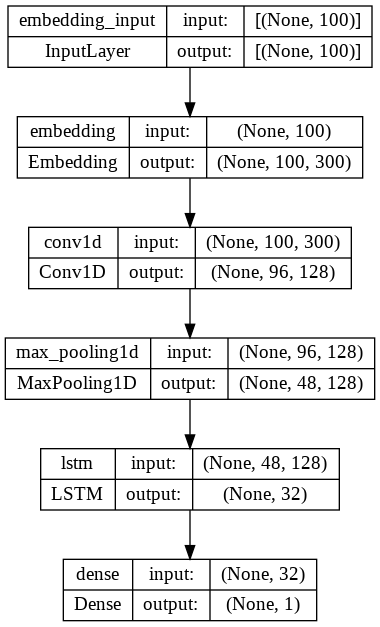

In [19]:
tf.keras.utils.plot_model(model=model, show_shapes=True)

In [31]:
history = model.fit(X_train,Y_train,epochs=10,batch_size=64,validation_data=(X_test,Y_test))

Epoch 1/10
11/11 [==============================] - 2s 171ms/step - loss: 0.1168 - accuracy: 0.9533 - val_loss: 1.4689 - val_accuracy: 0.4907
Epoch 2/10
11/11 [==============================] - 2s 165ms/step - loss: 0.1027 - accuracy: 0.9565 - val_loss: 1.4857 - val_accuracy: 0.5031
Epoch 3/10
11/11 [==============================] - 2s 162ms/step - loss: 0.0930 - accuracy: 0.9565 - val_loss: 1.5210 - val_accuracy: 0.5093
Epoch 4/10
11/11 [==============================] - 2s 200ms/step - loss: 0.0895 - accuracy: 0.9596 - val_loss: 1.5140 - val_accuracy: 0.5280
Epoch 5/10
11/11 [==============================] - 2s 181ms/step - loss: 0.0841 - accuracy: 0.9565 - val_loss: 1.5062 - val_accuracy: 0.5155
Epoch 6/10
11/11 [==============================] - 2s 165ms/step - loss: 0.1112 - accuracy: 0.9533 - val_loss: 1.5320 - val_accuracy: 0.5217
Epoch 7/10
11/11 [==============================] - 2s 164ms/step - loss: 0.1097 - accuracy: 0.9487 - val_loss: 1.4825 - val_accuracy: 0.5528
Epoch 

In [43]:
loss_train,accuracy_train = model.evaluate(X_train,Y_train)
loss_test,accuracy_test = model.evaluate(X_test,Y_test)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('\nTraining accuracy = ',accuracy_train,'\n')
print('Test accuracy = ',accuracy_test,'\n')
print('Recall = ',recall_score(Y_test, Y_pred,average='macro'),'\n')
print('F1 =',f1_score(Y_test, Y_pred,average='macro'),'\n')
print('Precision = ',precision_score(Y_test, Y_pred,average='macro'))

6/6 [==============================] - 0s 30ms/step

Training accuracy =  0.9642301797866821 

Test accuracy =  0.5279502868652344 

Recall =  0.5 

F1 = 0.33195020746887965 

Precision =  0.2484472049689441


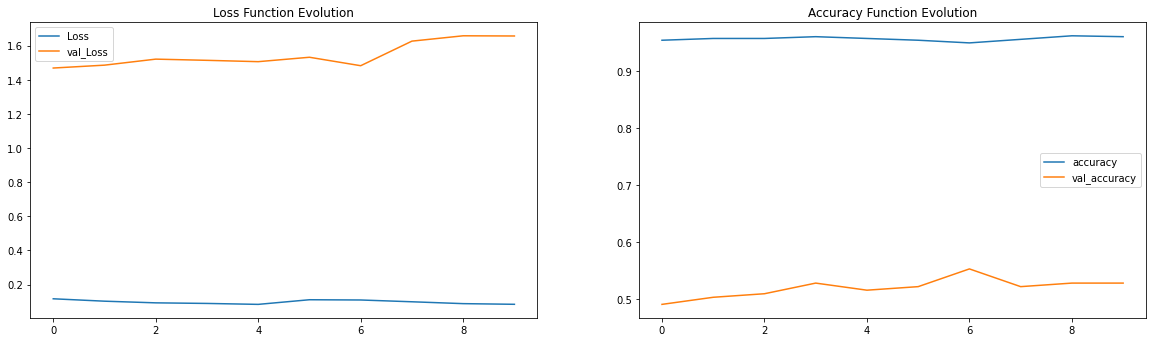

In [33]:
plt.figure(figsize=(20,25))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [34]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size,300,weights=[embedding_matrix],trainable=False,input_length = 100))
model_2.add(keras.layers.Bidirectional(LSTM(128))) 
model_2.add(Dense(128, activation = 'relu'))
model_2.add(Dense(1,activation= 'sigmoid'))

In [35]:
model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          2212200   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,684,521
Trainable params: 472,321
Non-trainable params: 2,212,200
_________________________________________________________________


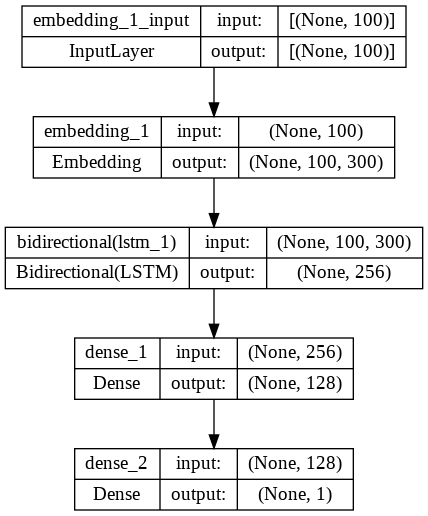

In [36]:
tf.keras.utils.plot_model(model=model_2, show_shapes=True)

In [41]:
history_2 = model_2.fit(X_train,Y_train,epochs=10,batch_size=64,validation_data=(X_test,Y_test))

Epoch 1/10
11/11 [==============================] - 8s 785ms/step - loss: 0.0834 - accuracy: 0.9642 - val_loss: 2.1614 - val_accuracy: 0.4845
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.0897 - accuracy: 0.9627 - val_loss: 2.1776 - val_accuracy: 0.4596
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.0800 - accuracy: 0.9580 - val_loss: 2.0652 - val_accuracy: 0.4472
Epoch 4/10
11/11 [==============================] - 11s 1s/step - loss: 0.0765 - accuracy: 0.9673 - val_loss: 2.0565 - val_accuracy: 0.4534
Epoch 5/10
11/11 [==============================] - 8s 696ms/step - loss: 0.0675 - accuracy: 0.9673 - val_loss: 2.2749 - val_accuracy: 0.4534
Epoch 6/10
11/11 [==============================] - 7s 596ms/step - loss: 0.0762 - accuracy: 0.9580 - val_loss: 2.1805 - val_accuracy: 0.4720
Epoch 7/10
11/11 [==============================] - 7s 602ms/step - loss: 0.0715 - accuracy: 0.9596 - val_loss: 2.2745 - val_accuracy: 0.5031
Epoch 8/10
1

In [42]:
loss_train,accuracy_train = model_2.evaluate(X_train,Y_train)
loss_test,accuracy_test = model_2.evaluate(X_test,Y_test)
Y_pred = np.argmax(model_2.predict(X_test),axis=1)
print('\nTraining accuracy = ',accuracy_train,'\n')
print('Test accuracy = ',accuracy_test,'\n')
print('Recall = ',recall_score(Y_test, Y_pred,average='macro'),'\n')
print('F1 =',f1_score(Y_test, Y_pred,average='macro'),'\n')
print('Precision = ',precision_score(Y_test, Y_pred,average='macro'))

6/6 [==============================] - 1s 141ms/step

Training accuracy =  0.9688957929611206 

Test accuracy =  0.48447203636169434 

Recall =  0.5 

F1 = 0.33195020746887965 

Precision =  0.2484472049689441


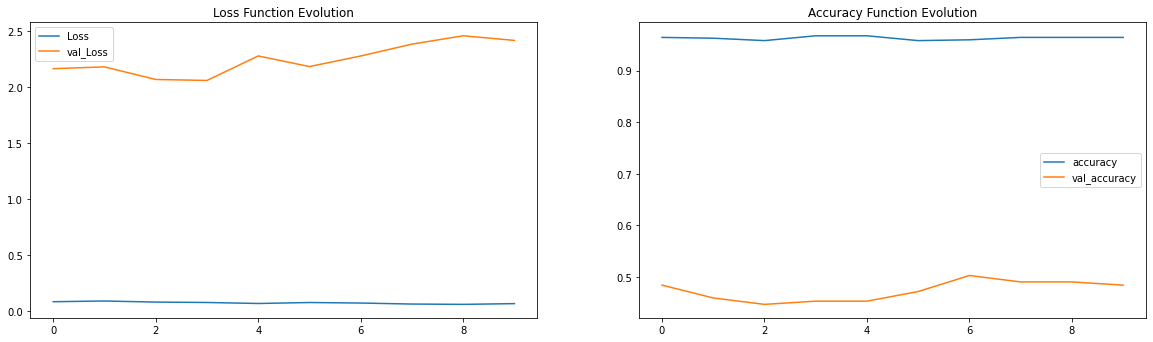

In [44]:
plt.figure(figsize=(20,25))

plt.subplot(4, 2, 1)
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()